# Affirmation Sample selection

In [1]:
import os
import json
import numpy as np
import pandas as pd
from copy import deepcopy
import scipy.stats as st
from scipy.optimize import minimize
from scipy.special import gamma
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
# import lib.galaxy_utilities as gu
import gzbuilder_analysis.parsing as parsing
import gzbuilder_analysis.aggregation as aggregation
import gzbuilder_analysis.rendering as rendering
from gzbuilder_analysis.rendering.sersic import _b
import gzbuilder_analysis.fitting as fitting
from asinh_cmap import asinh_cmap

In [2]:
models = pd.read_pickle('lib/models.pickle')

In [ ]:
def foo(m):
    return (
        m['disk'] is not None
        and m['bulge'] is not None
        and m['disk']['Re'] > m['bulge']['Re']
    )

In [5]:
chisq_mask = models['tuned_aggregate_chisq'] < 2
bulge_re_mask = models['tuned_aggregate'].apply(
    lambda m: (
        m['disk'] is not None
        and m['bulge'] is not None
        and m['disk']['Re'] > m['bulge']['Re']
    )
)
comb_mask = chisq_mask ^ bulge_re_mask

In [31]:
# disk_only = models['tuned_aggregate'][comb_mask].apply(
#     lambda m: (
#         m['disk'] is not None
#         and m['bulge'] is None
#         and m['bar'] is None
#         and len(m['spiral']) == 0
#     )    
# )
disk_only_idx = 21686502
disk_only_model = models['tuned_aggregate'].loc[disk_only_idx]
parsing.to_pandas(disk_only_model).unstack()

parameter,I,Re,c,mux,muy,n,q,roll
component,,,,,,,,
disk,0.107887,30.483476,2.0,89.538084,89.183218,1.0,0.762955,0.700746


21096874


parameter,I,Re,c,mux,muy,n,q,roll
component,,,,,,,,
bulge,0.101568,4.494064,2.0,55.583439,55.608295,2.730125,0.601521,0.491234
disk,0.119049,17.228302,2.0,54.903212,57.529685,1.000000,0.571617,0.774281


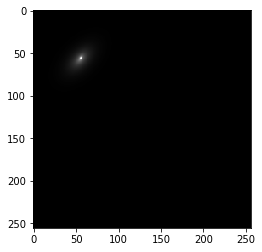

In [35]:
# disk_bulge = models['tuned_aggregate'][comb_mask].apply(
#     lambda m: (
#         m['disk'] is not None
#         and m['bulge'] is not None
#         and m['bulge']['n'] > 1
#         and m['bar'] is None
#         and len(m['spiral']) == 0
#     )    
# )
bulge_disk_idx = 21096874
bulge_disk_model = models['tuned_aggregate'].loc[bulge_disk_idx]
print(bulge_disk_idx)
plt.imshow(
    rendering.calculate_model(bulge_disk_model),
    cmap=asinh_cmap
)
parsing.to_pandas(bulge_disk_model).unstack()

In [67]:
diff_data_df = pd.read_pickle('lib/fitting_metadata.pkl')
# model_dict = models.loc[subject_id][model_type]
# diff_data = diff_data_df.loc[subject_id]
# psf = diff_data['psf']
# data = diff_data['galaxy_data']
# sigma_image = diff_data['sigma_image']

In [74]:
diff_data_df.loc[20902040].keys()

Index(['psf', 'pixel_mask', 'galaxy_data', 'montage_wcs', 'original_wcs',
       'sigma_image', 'width', 'size_diff'],
      dtype='object')

(-0.5, 162.5, 162.5, -0.5)

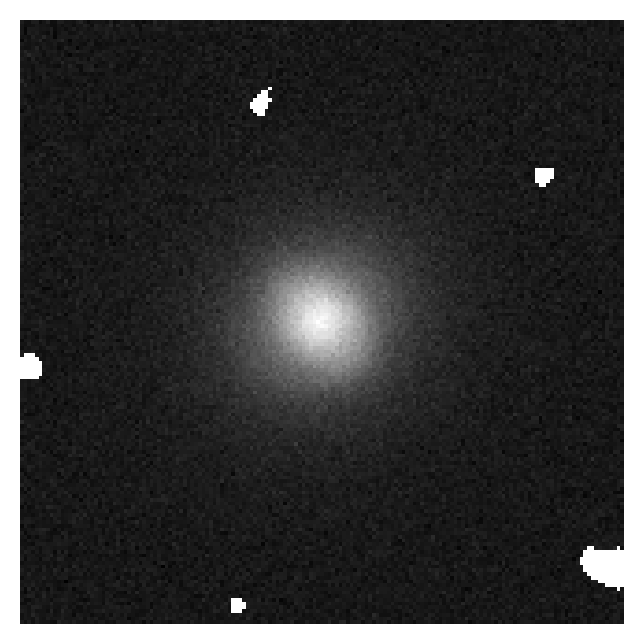

In [79]:
plt.figure(dpi=200)
plt.imshow(
    rendering.calculate_model(
        models['tuned_aggregate'][20902008],
        image_size=diff_data_df.loc[20902008]['galaxy_data'].shape,
        psf=diff_data_df.loc[20902008]['psf']
    ) + np.random.randn(*diff_data_df.loc[20902008]['galaxy_data'].shape) * diff_data_df.loc[20902008]['sigma_image'],
    cmap=asinh_cmap
)
plt.axis('off')

(-0.5, 257.5, 257.5, -0.5)

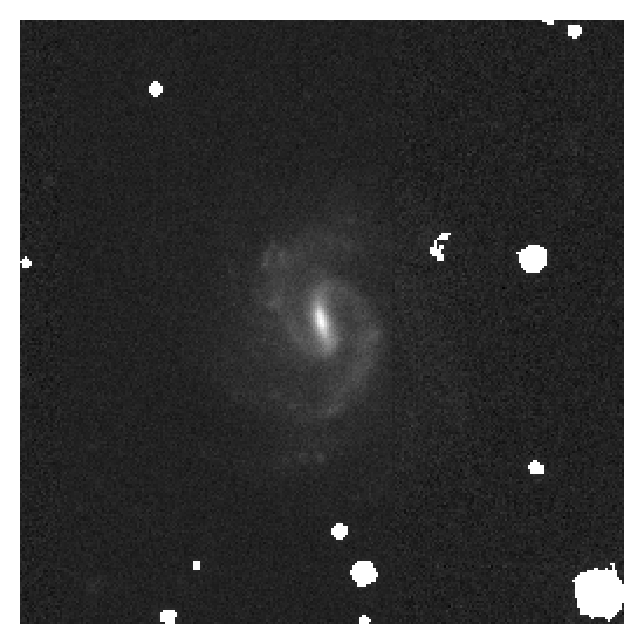

In [82]:
plt.figure(dpi=200)
plt.imshow(
    diff_data_df.loc[20902040]['galaxy_data'],
    cmap=asinh_cmap
)
plt.axis('off')

(-0.5, 257.5, 257.5, -0.5)

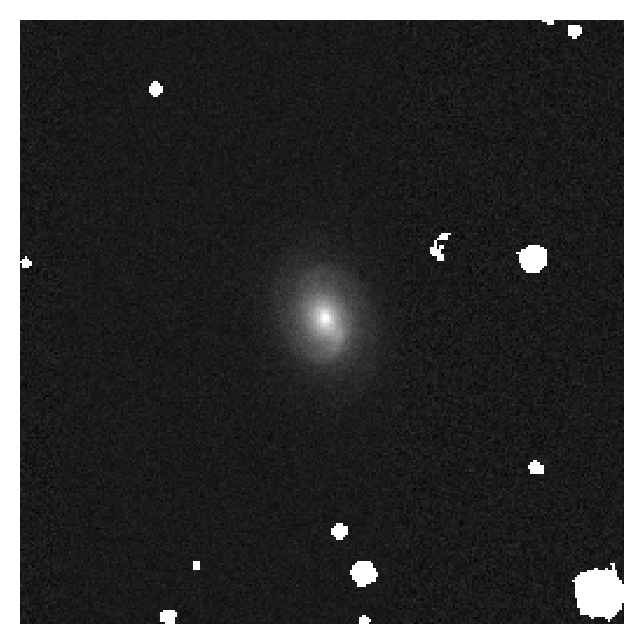

In [85]:
plt.figure(dpi=200)
plt.imshow(
    rendering.calculate_model(
        models['aggregate'][20902040],
        image_size=diff_data_df.loc[20902040]['galaxy_data'].shape,
        psf=diff_data_df.loc[20902040]['psf']
    ) + np.random.randn(*diff_data_df.loc[20902040]['galaxy_data'].shape) * diff_data_df.loc[20902040]['sigma_image'],
    cmap=asinh_cmap
)
plt.axis('off')

In [63]:
disk_bulge_bar = models['tuned_aggregate'][comb_mask].apply(
    lambda m: (
        m['disk'] is not None
        and m['bulge'] is not None
        and m['bar'] is not None
        and m['bulge']['Re'] > 0
        and m['bulge']['I'] > 0
        and m['bar']['Re'] > 0
        and m['bar']['I'] > 0
#         and len(m['spiral']) == 0
    )    
)
models['tuned_aggregate'][comb_mask][disk_bulge_bar]
# disk_bulge_bar_idx = np.random.choice(models['tuned_aggregate'][comb_mask][disk_bulge_bar].index)
# disk_bulge_bar_model = models['tuned_aggregate'].loc[disk_bulge_bar_idx]
# print(disk_bulge_bar_idx)
# plt.imshow(
#     rendering.calculate_model(disk_bulge_bar_model, image_size=(100, 100)),
#     cmap=asinh_cmap
# )
# parsing.to_pandas(disk_bulge_bar_model).unstack()

20902034    {'disk': {'I': 0.04962049307361233, 'Re': 15.6...
20902035    {'disk': {'I': 0.09559894655820911, 'Re': 13.9...
20902063    {'disk': {'I': 0.010101496412319163, 'Re': 37....
20902071    {'disk': {'I': 0.05158997678400973, 'Re': 11.6...
20902077    {'disk': {'I': 0.15089969435740305, 'Re': 17.5...
21096902    {'disk': {'I': 0.05791826484206261, 'Re': 24.0...
Name: tuned_aggregate, dtype: object